In [1]:
import os,sys
import numpy as np
from collections import namedtuple
import tqdm
import glob
import math
import random
import inspect
import os.path as osp
from pathlib import Path
import itertools
from itertools import chain
import numpy as np
import pandas as pd
import multiprocessing
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from importlib import reload

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch_geometric.data import Data, DataLoader, DataListLoader
from torch_geometric.nn import EdgeConv, global_mean_pool, DataParallel
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import Data,Dataset
from torch_scatter import scatter_mean, scatter
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import MetaLayer, EdgeConv, global_mean_pool, DynamicEdgeConv
import h5py

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)

sys.path.append(os.path.abspath(os.path.join('../../')))
sys.path.append(os.path.abspath(os.path.join('../../DarkFlow/darkflow/')))
import DarkFlow.darkflow.networks.flows as flows

import models_torch.models as models
reload(models)
import models_torch.losses as losses
reload(losses)
import utils_torch.scaler
reload(utils_torch.scaler)
import utils_torch.preprocessing as prepr
import utils_torch.plot_util as plot
reload(plot)
import utils_torch.train_util as train
reload(train)
import graph_data.graph_data as graph_data
reload(graph_data)
import utils_torch.model_summary as summary
reload(summary)




<module 'utils_torch.model_summary' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils_torch/model_summary.py'>

In [3]:
data_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/'
dataset = graph_data.GraphDataset(root=data_dir,n_jets=1e5)
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
   
use_generator = False
if use_generator:
    validation_split = 0.2
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    if dataset_size > 2:
        split = int(np.floor(validation_split * dataset_size))
    else: 
        split = 1
    print(dataset_size,split)
    random_seed= 1001

    train_subset, val_subset = torch.utils.data.random_split(dataset, [dataset_size - split, split],
                                                             generator=torch.Generator().manual_seed(random_seed))
    print("train subset dim:", len(train_subset))
    print("validation subset dim", len(val_subset))
    dataloaders = {
        'train':  DataLoader(train_subset, batch_size=128, shuffle=True),
        'val':   DataLoader(val_subset, batch_size=128, shuffle=True)
    }
    print("train_dataloader dim:", len(dataloaders['train']))
    print("val dataloader dim:", len(dataloaders['val']))
else : 
    in_memory_datas = dataset.return_inmemory_data_no_loop() 
   # in_memory_datas = dataset.return_inmemory_data() 

In [4]:
pf_cands,jet_prop = dataset.pf_cands,dataset.jet_prop
pf_cands_t = torch.cat([torch.tensor(pf_cands[i], dtype=torch.float) for i in range(len(pf_cands))])
#Plot consistuents and jet features prepared for the graph! (but before any normalization)
pf_feats = 'px,py,pz,E,pt,eta,phi'.split(',')
jet_feats = 'N_constituents,M,Pt,Eta,Phi'.split(',')


save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
vande_plot.plot_features(pf_cands_t.numpy(), pf_feats ,'Normalized' , 'QCD', plotname='{}plot_pf_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)
vande_plot.plot_features(jet_prop[:,0:-1], jet_feats ,'Normalized' , 'QCD', plotname='{}plot_jet_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)


In [4]:
#scaler = standardize(train_subset) # I dont think that this works for the dataset implementation as it is done now, implement scaler as part of dataset ? 
scaler = prepr.standardize(in_memory_datas,minmax_idx=[3,4],log_idx=[3,4]) 

dataloaders = {
    'train':  DataLoader(in_memory_datas, batch_size=128, shuffle=True)
    }
print("train_dataloader dim:", len(dataloaders['train']))

#dataset.get(0).u

train_dataloader dim: 1563


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
pf_cands_norm = torch.cat([torch.tensor(in_memory_datas[i].x, dtype=torch.float) for i in range(len(in_memory_datas))])
#Plot consistuents and jet features prepared for the graph! (after normalization)
pf_feats = 'px,py,pz,E,pt,eta,phi'.split(',')
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats_normalized/'
vande_plot.plot_features(pf_cands_norm.numpy(), pf_feats ,'Normalized' , 'QCD', plotname='{}plot_pf_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)


In [12]:
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
multi_gpu = False #torch.cuda.device_count()>1
print(device)

cuda:0


In [7]:
# model
input_dim = 7
output_dim = 4#7#4#4,7
big_dim = 32
hidden_dim = 2
#model = models.EdgeNet(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)
#model = models.EdgeNetVAE(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)
model = models.PlanarEdgeNetVAE(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr = 10e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, threshold=1e-6)

model.to(device)
print(model)
summary.gnn_model_summary(model)

PlanarEdgeNetVAE(
  (mu_layer): Linear(in_features=32, out_features=2, bias=True)
  (var_layer): Linear(in_features=32, out_features=2, bias=True)
  (batchnorm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  ))
  (decoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  ))
  (amor_u): Linear(in_features=32, out_features=12, bias=True)
  (amor_w): Linear(in_features=32, out_features=12, bias=True)
  (amor_b): Linear(in_features=32, out_features=6, bias=True)
  (flow_0): Planar(
    (h): Tanh()
    (softplus): Softplus(beta=1, threshold=20)
  )
  (flow_1): Planar(
    (h): Tanh()
  

In [8]:
#loss
#loss_ftn_obj = losses.LossFunction('mse_coordinates', device=device)
#loss_ftn_obj = losses.LossFunction('mse', device=device)
#loss_ftn_obj = losses.LossFunction('vae_loss_mse',beta=0.00001,device=device)
loss_ftn_obj = losses.LossFunction('vae_loss_mse_coord',beta=0.5,device=device)

# Training loop
n_epochs = 80
stale_epochs = 0
loss = 999999
#train_losses = []
for epoch in range(0, n_epochs):
    #loss = train(model, optimizer, loader, len(datas), 128, loss_ftn_obj)
    loss_tot,loss_reco,loss_kl = train.train(model, optimizer, dataloaders['train'], len(dataloaders['train'].dataset), dataloaders['train'].batch_size, loss_ftn_obj)
    #train_losses.append(loss)
    print('Epoch: {:02d}, Training Loss Tot, Reco, KL :  {:.4f},{:.4f}, {:.4f}'.format(epoch, loss_tot,loss_reco,loss_kl))

train loss tot = 0.1421053,train loss reco = 0.2777027,train loss kl = 0.0065078:  64%|██████████████████████████████████████████▍                       | 1006/1562.5 [06:13<03:26,  2.69it/s]


KeyboardInterrupt: 

In [20]:
reload(utils_torch.scaler)
reload(prepr)
reload(plot)

save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
inverse_standardization = True
#plot.plot_reco_for_loader(model, dataloaders['train'], device, scaler, inverse_standardization, 'test_train', osp.join(save_dir, 'reconstruction_post_train', 'train_reco_std_log_minmax_vae_planar_mseconv_kl_100k'), 'all_mseconv')
plot.plot_reco_for_loader(model,test_loader, device, scaler, inverse_standardization, 'test_train', osp.join(save_dir, 'reconstruction_post_train', 'train_reco_std_log_minmax_vae_planar_mseconv_kl_100k'), 'all_mseconv')


In [8]:
latent = plot.gen_latent(model, dataloaders['train'], device)


In [9]:
mu_fts,log_var_fts,z_0_fts,z_last_fts = latent

In [18]:
#!{sys.executable} -m pip install seaborn
#import seaborn as sns

100000

In [19]:
test_loader = DataLoader(in_memory_datas[0:10000], batch_size=128, shuffle=True)


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


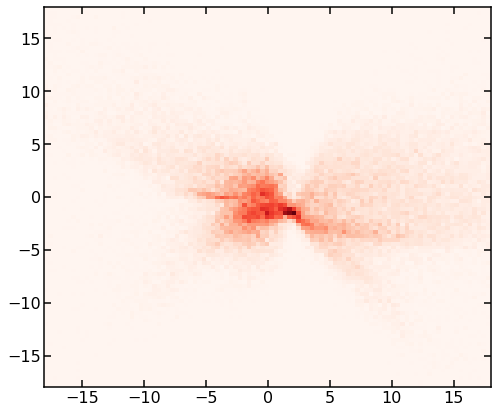

In [11]:
bins = np.linspace(-18,18,100)
plt.hist2d(z_last_fts[:,0].numpy(), y=z_last_fts[:,1].numpy(), bins=(bins, bins), cmap=plt.cm.Reds)
plt.show()

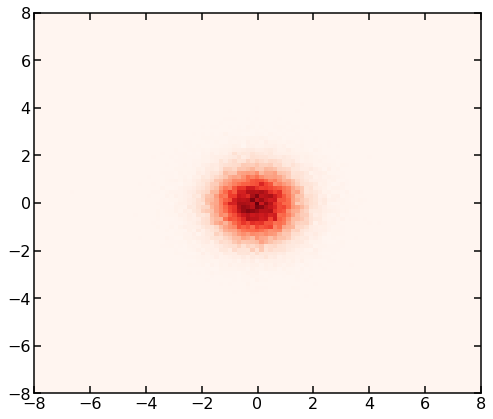

In [12]:
bins = np.linspace(-8,8,100)
plt.hist2d(z_0_fts[:,0].numpy(), y=z_0_fts[:,1].numpy(), bins=(bins, bins), cmap=plt.cm.Reds)
plt.show()

In [13]:
loss_ftn_obj = losses.LossFunction('vae_loss_mse_coord',beta=0.00001,device=device)

loss_tot,loss_reco,loss_kl = train.test(model, dataloaders['train'], len(dataloaders['train'].dataset), dataloaders['train'].batch_size, loss_ftn_obj)

valid loss tot = 0.2198390,valid loss reco = 0.2198410,valid loss kl = 0.0202341: : 8it [00:00, 78.56it/s]                  


In [172]:
for data in dataloaders['train']:
    print(data.edge_index.shape)
    break

torch.Size([2, 389804])


In [9]:
test_loader =  DataLoader(in_memory_datas, batch_size=1, shuffle=True)

In [10]:
jets_losses = []
jets_losses_mse = []
jets_losses_kl = []
for k, data_batch in enumerate(test_loader):
    data_batch.to(device)
    jets_x = data_batch.x
    batch = data_batch.batch
    jets_rec, mu,log_var,_,_,_ = model(data_batch)
    njets = len(torch.unique(batch))
    losses = torch.zeros((njets), dtype=torch.float32)
    losses_mse = torch.zeros((njets), dtype=torch.float32)
    losses_kl = torch.zeros((njets), dtype=torch.float32)
    for ib in torch.unique(batch):
        losses[ib] = loss_ftn_obj.loss_ftn(jets_rec[batch==ib], jets_x[batch==ib], mu, log_var)[0]
        losses_mse[ib] = loss_ftn_obj.loss_ftn(jets_rec[batch==ib], jets_x[batch==ib], mu, log_var)[1]
        losses_kl[ib] = loss_ftn_obj.loss_ftn(jets_rec[batch==ib], jets_x[batch==ib], mu, log_var)[2]
    jets_losses.append(losses)
    jets_losses_mse.append(losses_mse)
    jets_losses_kl.append(losses_kl)

In [11]:
jets_losses = np.array([jets_losses[i].detach().numpy() for i in range(len(jets_losses))]).reshape(-1)
jets_losses_mse = np.array([jets_losses_mse[i].detach().numpy() for i in range(len(jets_losses))]).reshape(-1)
jets_losses_kl = np.array([jets_losses_kl[i].detach().numpy() for i in range(len(jets_losses))]).reshape(-1)

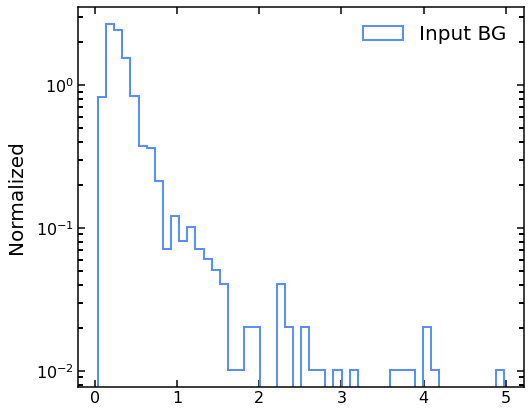

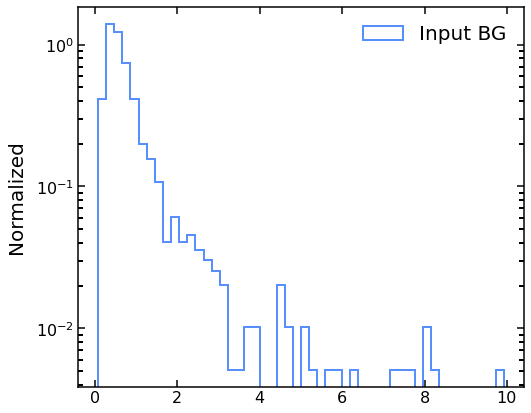

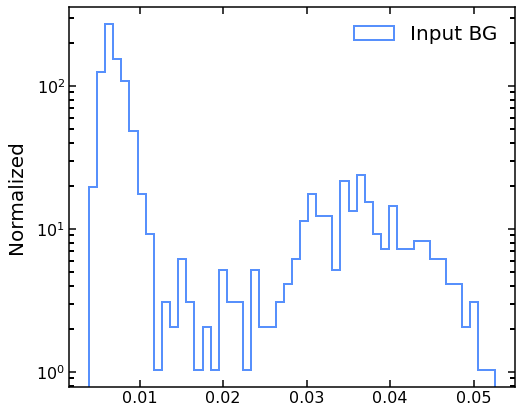

In [33]:
for loss in [jets_losses,jets_losses_mse,jets_losses_kl]:
    xmin = np.quantile(loss,0.05)
    xmax = np.quantile(loss,0.98)
    plt.figure()
    plt.hist(loss, bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

In [115]:
jet_pair_1 = graph_data.PairJetsData(in_memory_datas[0].edge_index, in_memory_datas[0].x, in_memory_datas[1].edge_index, in_memory_datas[1].x)
jet_pair_2 = graph_data.PairJetsData(in_memory_datas[2].edge_index, in_memory_datas[2].x, in_memory_datas[3].edge_index, in_memory_datas[3].x)
jet_pair = [jet_pair_1,jet_pair_2,jet_pair_2,jet_pair_2,jet_pair_2,jet_pair_2]


In [157]:
jet_pair_loader = DataLoader(jet_pair, batch_size=2, shuffle=False,follow_batch=['x_1', 'x_2'])
jet_pair_loader_all = DataLoader(jet_pair, batch_size=2, shuffle=False)
